# Car price estimation

This is a dataset from the [Vehicle Dataset From Cardekho in Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho). It contains data from cars on sale in Cardekho (a vehicle sale portal in India)

In [1]:
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

from utils import mean_absolute_percentage_error

ImportError: cannot import name 'mean_absolute_percentage_error' from 'utils' (/home/pol/.local/lib/python3.8/site-packages/utils/__init__.py)

There are 3 different CSV, but the one named ```Car details v3.csv``` is the best in my opinion.

In [2]:
raw_df = pd.read_csv("data/cardekho/Car details v3.csv")
raw_df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [3]:
raw_df.count()

name             8128
year             8128
selling_price    8128
km_driven        8128
fuel             8128
seller_type      8128
transmission     8128
owner            8128
mileage          7907
engine           7907
max_power        7913
torque           7906
seats            7907
dtype: int64

We can see there are some missing values in the last 5 columns. But still it's a very complete dataset

In [4]:
raw_df.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

There are many columns that are ```object``` (strings them all). That's why this columns do not appear at the correlation matrix.

In [5]:
raw_df.corr()

,year,selling_price,km_driven,seats
year,1.000000,0.414092,-0.418006,-0.009144
selling_price,0.414092,1.000000,-0.225534,0.041358
km_driven,-0.418006,-0.225534,1.000000,0.227336
seats,-0.009144,0.041358,0.227336,1.000000


Let's create one silly model using only the columns 'year' and 'km_driven'

In [6]:
df = raw_df.copy()
df["euros"] = df["selling_price"] * 0.011  # Convert to euros so it's easier for us to understand the numbers
features = [
    "year",
    "km_driven",
]
target = "euros"
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (6502, 2)
X_test shape: (1626, 2)
y_train shape: (6502,)
y_test shape: (1626,)


In [7]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
linear_y_pred = linear_model.predict(X_test)

In [8]:
results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = linear_y_pred.astype(int)
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df.head(5)

,year,km_driven,y_real,y_pred,err,%_err
1392,2005,80000,2750.0,-520,3270.0,118.909091
7778,2017,45000,14102.0,10180,3922.0,27.811658
3727,2019,60000,7700.0,11664,-3964.0,-51.480519
6630,2020,15000,5500.0,13160,-7660.0,-139.272727
103,2016,100000,2970.0,8539,-5569.0,-187.508418


This results are horrible. There are indeed negative values in our predictions. Don't be harsh, this is a linear model after all.

The most commonly used metrics to evaluate a regression model are the RMSE (Root Mean Squared Error) and MAPE (Mean Absolute Percentage Error). They are pretty self explanatory, aren't they?

In [9]:
print(f"RMSE: {mean_squared_error(y_test, linear_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, linear_y_pred)}")
print(f"R^2: {r2_score(y_test, linear_y_pred)}")

RMSE: 7057.002599595892
MAPE: 89.88796385823161
R^2: 0.16323632984102454


So our dummy linear model differs to the reality by 7k euros and 90% (on average).

Let's do something more serious now.

In [10]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)
gbm_y_pred = gbm_model.predict(X_test)

In [11]:
results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df.head()

,year,km_driven,y_real,y_pred,err,%_err
1392,2005,80000,2750.0,1468,1282.0,46.618182
7778,2017,45000,14102.0,19649,-5547.0,-39.334846
3727,2019,60000,7700.0,8411,-711.0,-9.233766
6630,2020,15000,5500.0,6565,-1065.0,-19.363636
103,2016,100000,2970.0,7762,-4792.0,-161.346801


In [12]:
print(f"RMSE: {mean_squared_error(y_test, gbm_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gbm_y_pred)}")
print(f"R^2: {r2_score(y_test, gbm_y_pred)}")

RMSE: 5401.867564062352
MAPE: 56.44218309359429
R^2: 0.5097132841642201


That's better.

But let's try to use the other variables.

In [13]:
df = raw_df.dropna().copy()
df["euros"] = df["selling_price"] * 0.011  # Easier for us to understant euros instead of indian rupees, right?
# This columns have values in the format "X unit"
for col in ["engine", "max_power", "mileage"]:
    df[f"{col}_asfloat"] = df[col].apply(lambda x: x.split()[0]).astype(float)
# This are categorical columns
for col in ["fuel", "seller_type", "transmission", "owner"]:
    df[col] = df[col].astype("category")
    df[f"{col}_encoded"] = df[col].cat.codes    

In [14]:
df.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,...,torque,seats,euros,engine_asfloat,max_power_asfloat,mileage_asfloat,fuel_encoded,seller_type_encoded,transmission_encoded,owner_encoded
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,...,190Nm@ 2000rpm,5.0,4950.0,1248.0,74.00,23.40,1,1,1,0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,...,250Nm@ 1500-2500rpm,5.0,4070.0,1498.0,103.52,21.14,1,1,1,2
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,...,"12.7@ 2,700(kgm@ rpm)",5.0,1738.0,1497.0,78.00,17.70,3,1,1,4
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,...,22.4 kgm at 1750-2750rpm,5.0,2475.0,1396.0,90.00,23.00,1,1,1,0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,...,"11.5@ 4,500(kgm@ rpm)",5.0,1430.0,1298.0,88.20,16.10,3,1,1,0


In [15]:
df.corr()

,year,selling_price,km_driven,seats,euros,engine_asfloat,max_power_asfloat,mileage_asfloat,fuel_encoded,seller_type_encoded,transmission_encoded,owner_encoded
year,1.000000,0.412302,-0.428548,-0.007923,0.412302,0.018263,0.226598,0.328544,-0.040414,-0.144423,-0.249002,-0.472522
selling_price,0.412302,1.000000,-0.222158,0.041617,1.000000,0.455682,0.749674,-0.126280,-0.193332,-0.337022,-0.590269,-0.224413
km_driven,-0.428548,-0.222158,1.000000,0.227259,-0.222158,0.206031,-0.038159,-0.172980,-0.270453,0.120516,0.201186,0.281945
seats,-0.007923,0.041617,0.227259,1.000000,0.041617,0.611103,0.191999,-0.451700,-0.341640,0.052688,0.072722,0.028853
euros,0.412302,1.000000,-0.222158,0.041617,1.000000,0.455682,0.749674,-0.126280,-0.193332,-0.337022,-0.590269,-0.224413
engine_asfloat,0.018263,0.455682,0.206031,0.611103,0.455682,1.000000,0.703975,-0.576408,-0.486471,-0.091856,-0.283206,0.011301
max_power_asfloat,0.226598,0.749674,-0.038159,0.191999,0.749674,0.703975,1.000000,-0.374621,-0.282335,-0.248180,-0.541870,-0.107059
mileage_asfloat,0.328544,-0.126280,-0.172980,-0.451700,-0.126280,-0.576408,-0.374621,1.000000,-0.083432,-0.019847,0.178986,-0.162436
fuel_encoded,-0.040414,-0.193332,-0.270453,-0.341640,-0.193332,-0.486471,-0.282335,-0.083432,1.000000,0.110267,-0.034839,-0.030725
seller_type_encoded,-0.144423,-0.337022,0.120516,0.052688,-0.337022,-0.091856,-0.248180,-0.019847,0.110267,1.000000,0.230112,0.142435


In [16]:
features = [
    "year",
    "km_driven",
    "seats",
    "engine_asfloat",
    "max_power_asfloat",
    "mileage_asfloat",
    "fuel_encoded",
    "seller_type_encoded",
    "transmission_encoded",
    "owner_encoded",
]
target = "euros"
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

gbm_hyperparams = {
    'n_estimators': 100,
    'max_depth': 10,
    'learning_rate': 0.1,
    'loss': 'ls'
}
gbm_model = GradientBoostingRegressor(**gbm_hyperparams)
t0 = time.time()
gbm_model.fit(X_train, y_train)
print(f"Elapsed time training: {time.time() - t0} seconds")
t0 = time.time()
gbm_y_pred = gbm_model.predict(X_test)
print(f"Elapsed time predicting: {time.time() - t0} seconds")

print(f"RMSE: {mean_squared_error(y_test, gbm_y_pred)**0.5}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, gbm_y_pred)}")
print(f"R^2: {r2_score(y_test, gbm_y_pred)}")

results_df = X_test.copy()
results_df["y_real"] = y_test
results_df["y_pred"] = gbm_y_pred.astype(int)
results_df["err"] = results_df["y_real"] - results_df["y_pred"]
results_df["%_err"] = results_df["err"] / results_df["y_real"] * 100
results_df.head()


X_train shape: (6324, 10)
X_test shape: (1582, 10)
y_train shape: (6324,)
y_test shape: (1582,)
Elapsed time training: 1.6559221744537354 seconds
Elapsed time predicting: 0.03678464889526367 seconds
RMSE: 1348.5025299104761
MAPE: 14.749846790641508
R^2: 0.9701590827566675


,year,km_driven,seats,engine_asfloat,max_power_asfloat,mileage_asfloat,fuel_encoded,seller_type_encoded,transmission_encoded,owner_encoded,y_real,y_pred,err,%_err
338,2011,90000,5.0,1248.0,73.9,19.30,1,1,1,1,2915.0,3328,-413.0,-14.168096
4632,2014,70000,5.0,1248.0,74.0,23.40,1,1,1,0,4950.0,5330,-380.0,-7.676768
7973,2015,170000,7.0,2494.0,100.6,12.99,1,1,1,0,15400.0,11369,4031.0,26.175325
5214,2012,35000,5.0,998.0,67.1,19.00,3,1,1,2,2145.0,2736,-591.0,-27.552448
2457,2011,49563,5.0,995.0,62.1,16.20,3,0,1,0,1760.0,1667,93.0,5.284091


Much better now. Let's make some plots.

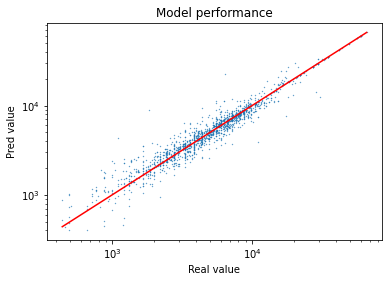

In [17]:
fig, ax = plt.subplots()
plot_range = [results_df["y_real"].min(), results_df["y_real"].max()] 
ax.set_title("Model performance")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")
ax.set_yscale("log")
ax.set_xscale("log")
ax.scatter(results_df["y_real"], results_df["y_pred"], s=0.1)
ax.plot(plot_range, plot_range, c="red")
plt.show()

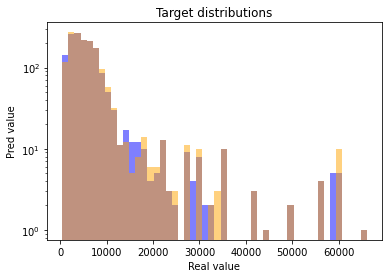

In [18]:
fig, ax = plt.subplots()
plot_range = [results_df["y_real"].min(), results_df["y_real"].max()] 
ax.set_title("Target distributions")
ax.set_ylabel("Pred value")
ax.set_xlabel("Real value")
ax.set_yscale("log")
ax.hist(results_df["y_real"], bins=50, color="blue", alpha=0.5, range=plot_range)
ax.hist(results_df["y_pred"], bins=50, color="orange", alpha=0.5, range=plot_range)
plt.show()

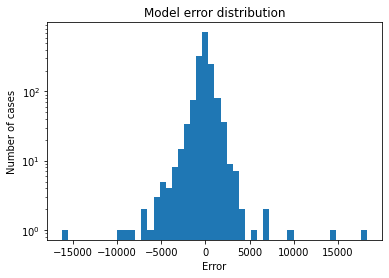

In [19]:
fig, ax = plt.subplots()
plot_range = [results_df["err"].min(), results_df["err"].max()] 
ax.set_title("Model error distribution")
ax.set_ylabel("Number of cases")
ax.set_xlabel("Error")
ax.set_yscale("log")
ax.hist(results_df["err"], bins=50)
plt.show()

# Shap

In [20]:
import shap

In [21]:
shap.initjs()

In [22]:
explainer = shap.TreeExplainer(gbm_model)

In [23]:
%%time
# This operation takes a while
shap_values = explainer.shap_values(X_test)

CPU times: user 10.4 s, sys: 330 ms, total: 10.7 s
Wall time: 11.8 s


In [24]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])

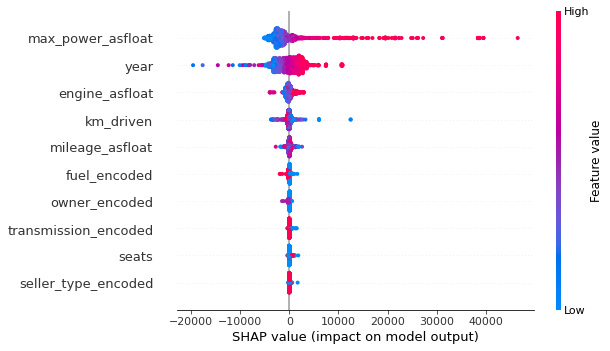

In [25]:
shap.summary_plot(shap_values, X_test)

In [26]:
shap.force_plot(explainer.expected_value, shap_values, X_test)

In [27]:
i = 1321
shap.force_plot(explainer.expected_value, shap_values[i,:], X_test.iloc[i,:])

In [28]:
X_test.iloc[i:i+1]

,year,km_driven,seats,engine_asfloat,max_power_asfloat,mileage_asfloat,fuel_encoded,seller_type_encoded,transmission_encoded,owner_encoded
5647,2018,50000,7.0,2755.0,174.5,14.24,1,1,1,0


In [29]:
df.loc[5647]

name                    Toyota Fortuner 2.8 4WD MT BSIV
year                                               2018
selling_price                                   3200000
km_driven                                         50000
fuel                                             Diesel
seller_type                                  Individual
transmission                                     Manual
owner                                       First Owner
mileage                                      14.24 kmpl
engine                                          2755 CC
max_power                                     174.5 bhp
torque                              420Nm@ 1400-2600rpm
seats                                                 7
euros                                             35200
engine_asfloat                                     2755
max_power_asfloat                                 174.5
mileage_asfloat                                   14.24
fuel_encoded                                    

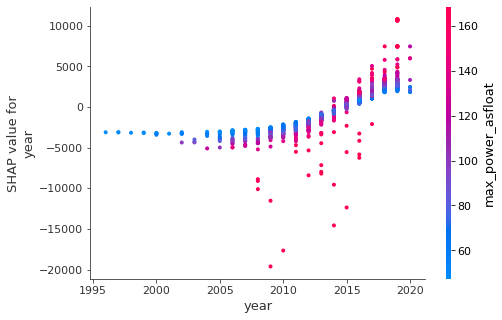

In [30]:
shap.dependence_plot("year", shap_values, X_test)

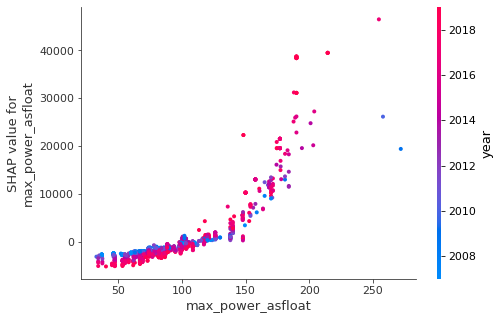

In [31]:
shap.dependence_plot("max_power_asfloat", shap_values, X_test)

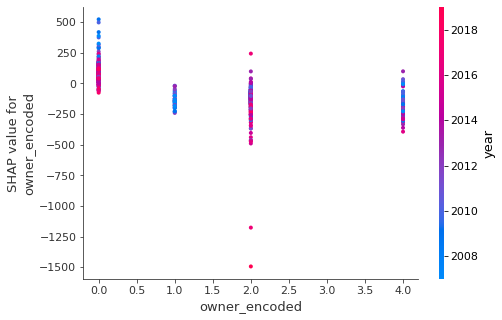

In [32]:
shap.dependence_plot("owner_encoded", shap_values, X_test)

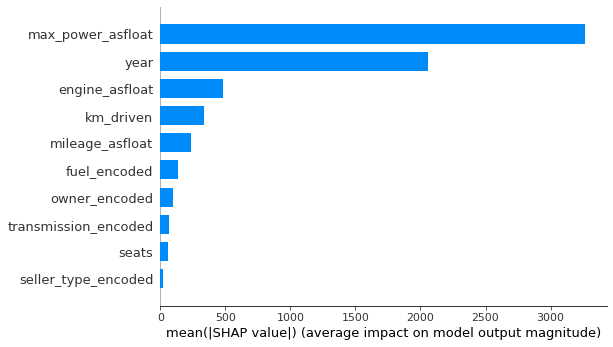

In [33]:
shap.summary_plot(shap_values, X_test, plot_type="bar")